# **V5 on Synthetic Datatest**

In [1]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from utils.wrapper import YOLOAPIWrappper
from utils.pipeline import CPPipeline

### **Multiplicative**

In [2]:
v5 = '../utils/v5/bestv5.onnx'
yolov5_detector_synth = YOLOAPIWrappper(v5,file_path='../calibration/calibv5_synth_m.pickle', conf_thres=0.7, iou_thres=0.5)
pipev5_synth = CPPipeline(yolov5_detector_synth, test_set='test_synth', method='multiplicative' )

In [3]:
X_train, y_train, labels_train= pipev5_synth.extract_yolo_dataset()
X_train, X_val, y_train, y_val, labels_train, labels_val = pipev5_synth.calibration_and_val(X_train, y_train, labels_train)

In [4]:
conformal_predictor = pipev5_synth.pipeline( X_train=X_train, y_train= y_train, labels_train= labels_train)

Predictions: [[1345.57763672 1239.2442627  1618.08813477 1438.55651855]
 [ 886.05023193  982.3972168  1111.93261719 1164.37670898]
 [ 655.53692627 1250.96252441  708.29278564 1317.50183105]
 ...
 [ 589.39331055 1047.36291504  843.47033691 1175.39343262]
 [ 639.62579346 1094.87536621  817.97613525 1225.84802246]
 [1565.59301758 1080.66894531 1817.16357422 1245.32128906]]
Matched Ground Truths: [[1339. 1240. 1610. 1440.]
 [ 879.  985. 1118. 1164.]
 [ 650. 1254.  708. 1322.]
 ...
 [ 593. 1044.  846. 1172.]
 [ 640. 1095.  811. 1227.]
 [1567. 1086. 1809. 1243.]]
Images: ['/home/aws_install/data/yolo_database/images/test_synth/WSSS_02L_35_23.jpeg', '/home/aws_install/data/yolo_database/images/test_synth/LEMD_32R_35_21.jpeg', '/home/aws_install/data/yolo_database/images/test_synth/RJAA_34R_35_05.jpeg', '/home/aws_install/data/yolo_database/images/test_synth/MDSD_17_35_28.jpeg', '/home/aws_install/data/yolo_database/images/test_synth/LFRS_21_35_05.jpeg', '/home/aws_install/data/yolo_database/i

Predictions: (array([[ 740.3279 ,  921.65533, 1428.3242 , 1320.395  ]], dtype=float32), array([0.980978], dtype=float32))
Marginal coverage: 1.0
Average area: 348785.90625
Confidence score : [0.980978]


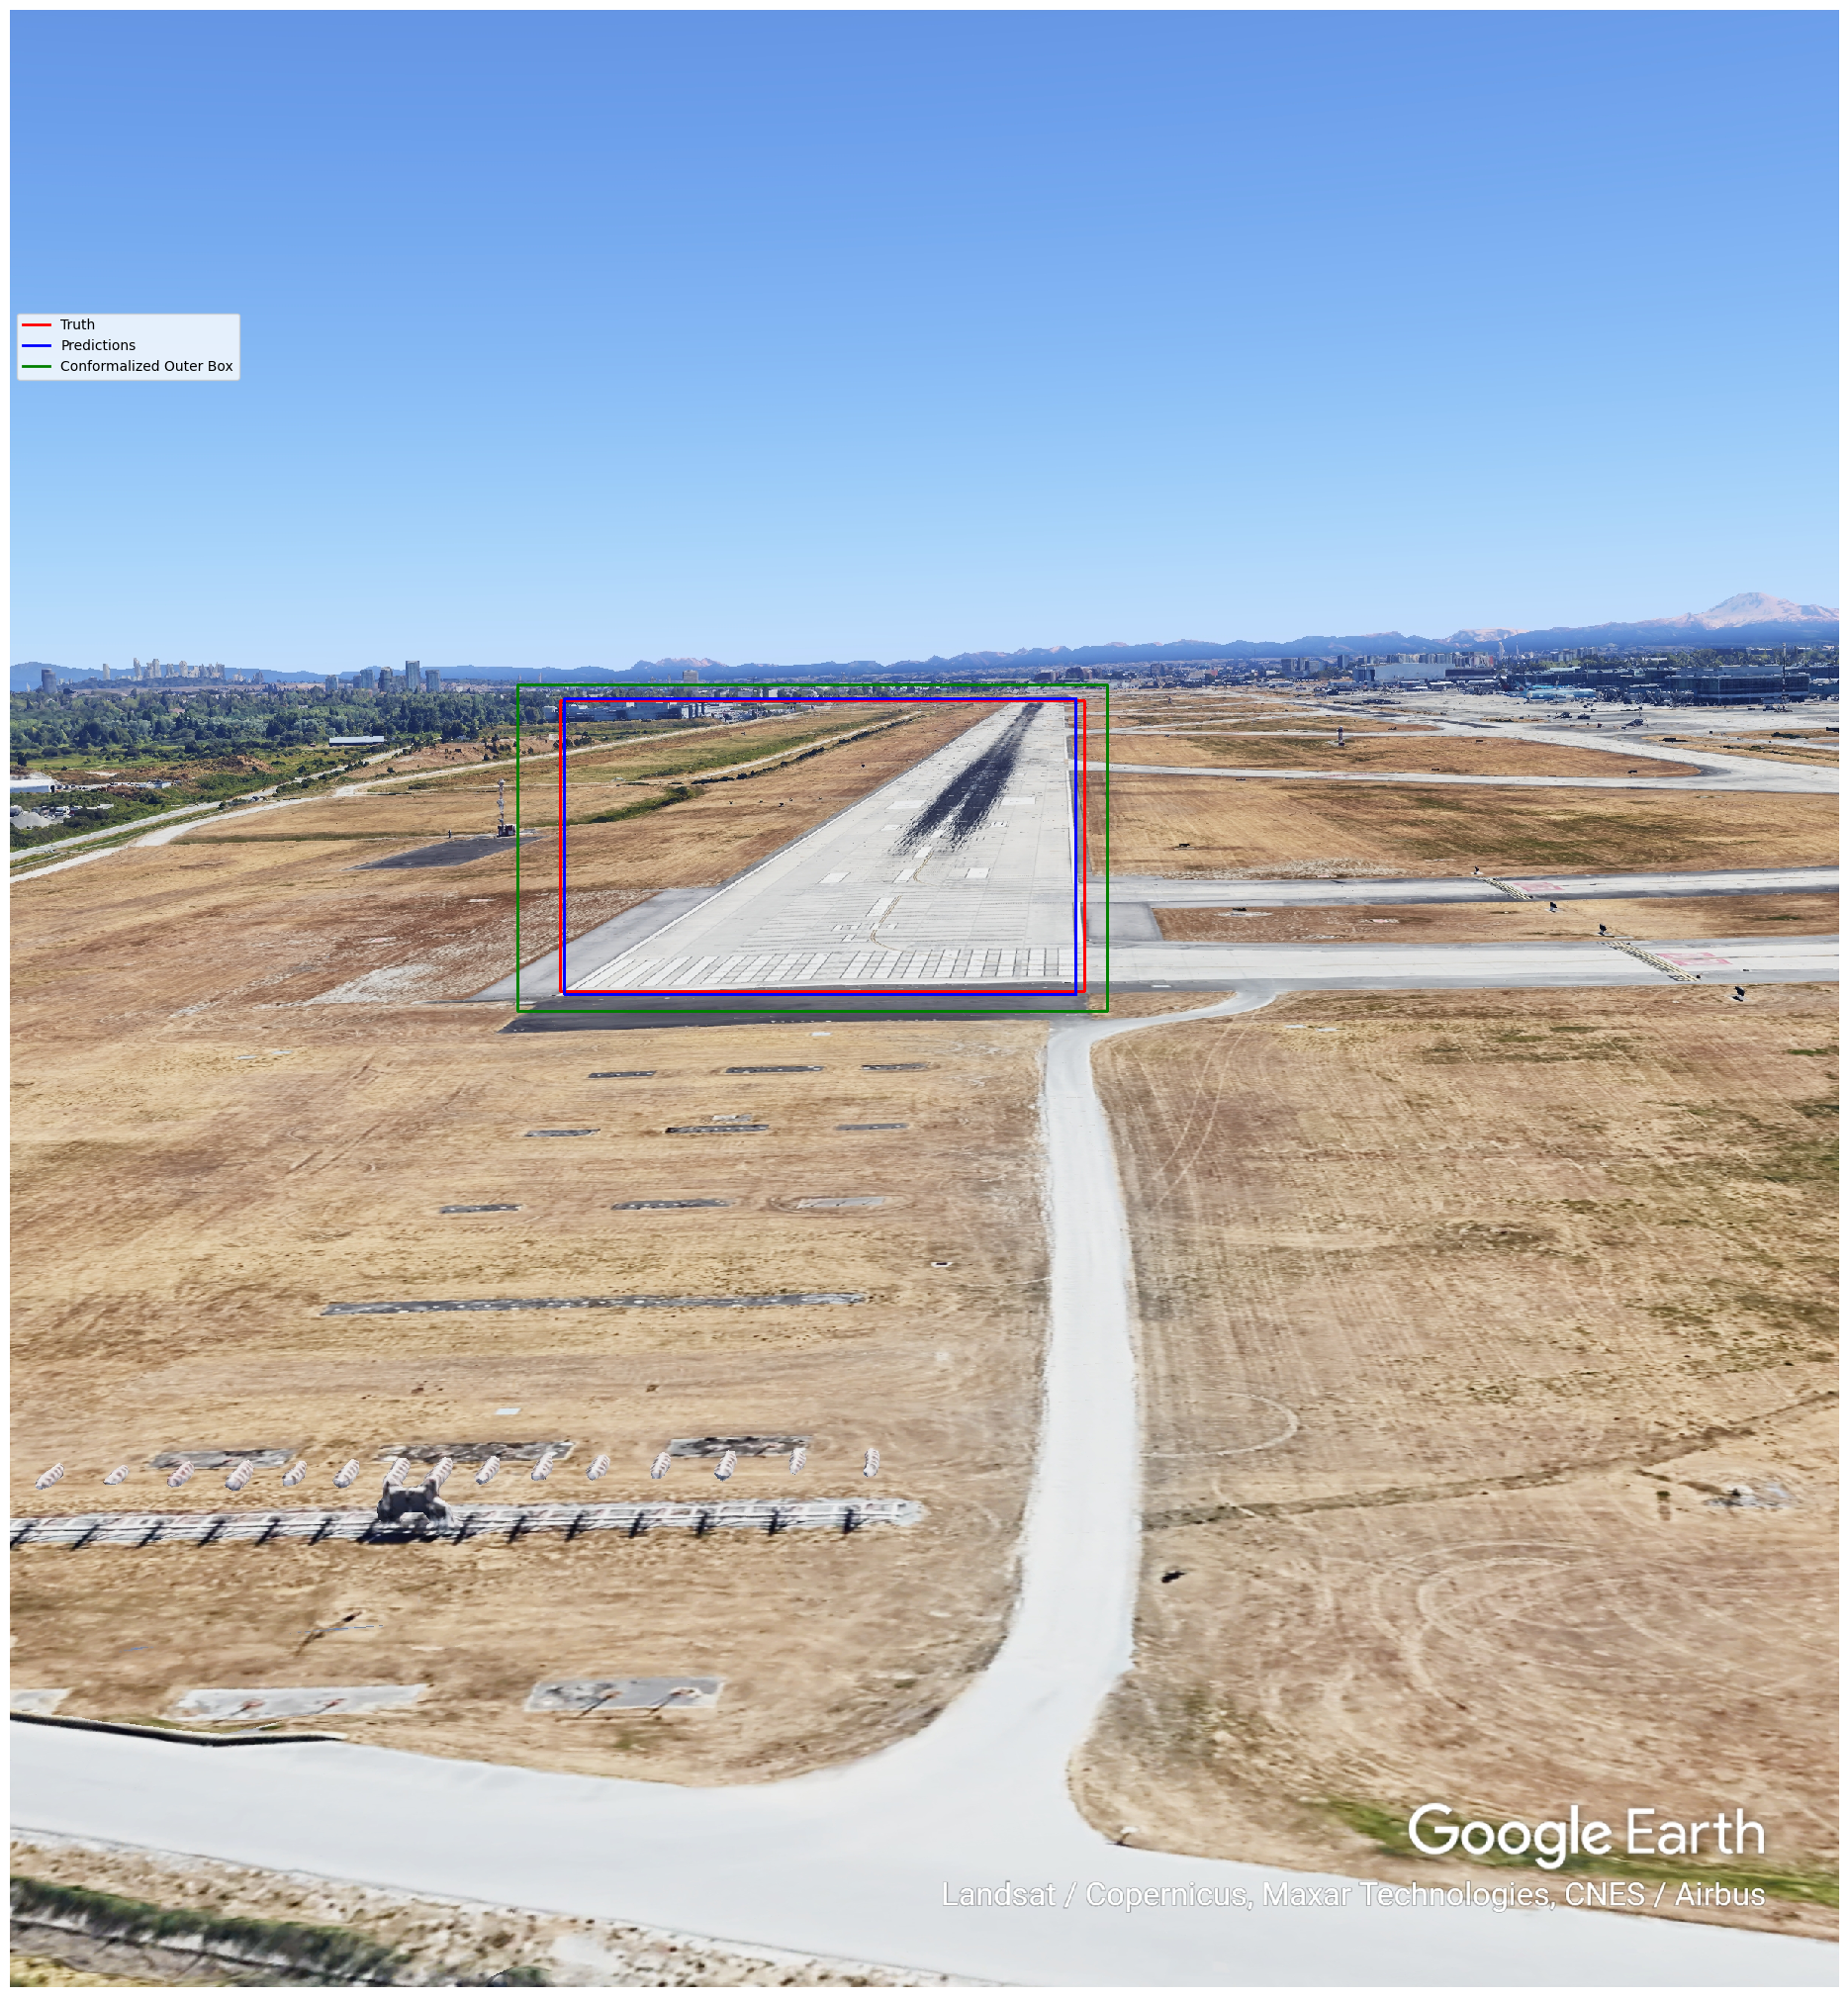

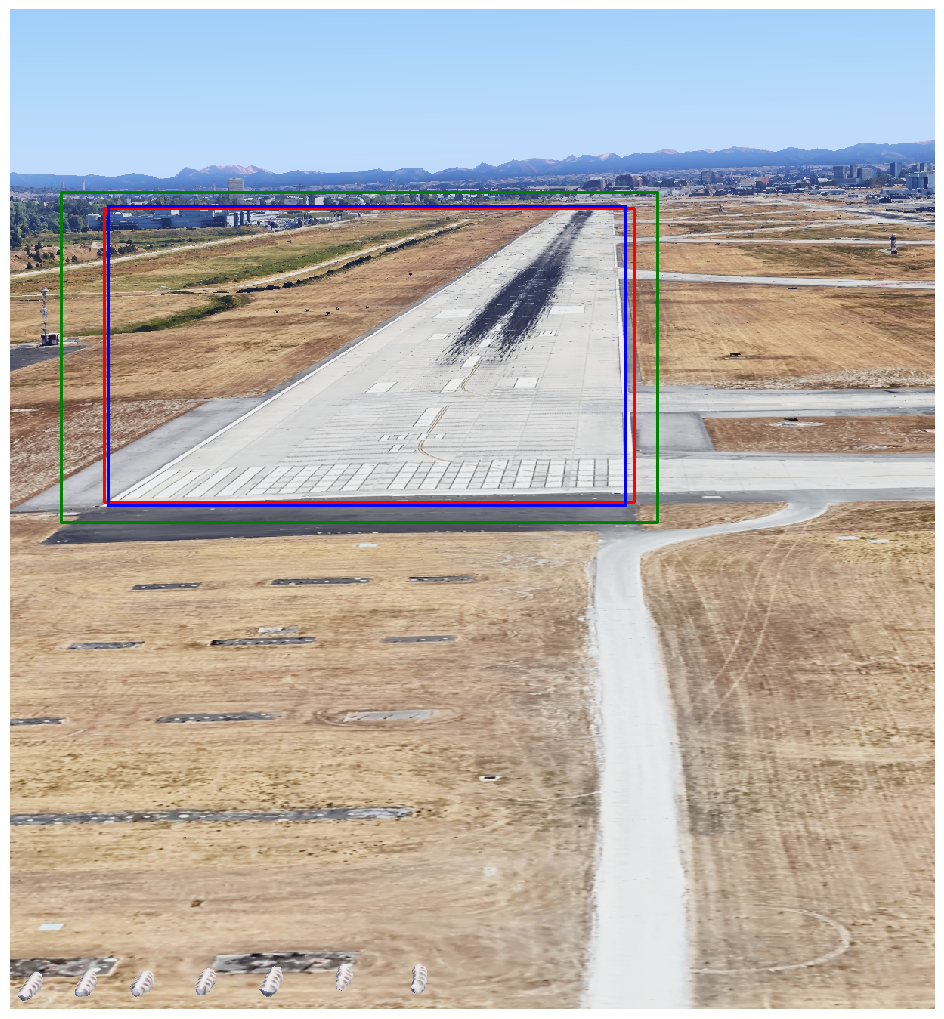

In [5]:
pipev5_synth.infer_eval_single_image(
    conformal_predictor, 
    X_val[83],  # Image path at index 5
    y_val[83],  # Ground truth bounding boxes at index 5
    labels_val[83],  # Labels at index 5
    None  # `y_new_api` is set to None, so the function will compute it internally
)

In [6]:
y_pred_val, y_true_val, images_val, classes_val,score_val, box_inner_val, box_outer_val = pipev5_synth.infer_all_images(conformal_predictor,X_val, y_val, labels_val, visualize = False)

Number of images: 443
Number of images without predictions: 31
Number of images with predictions: 412


In [7]:
average_glo_area, cover = pipev5_synth.average_cover_and_area(y_pred_val, y_true_val, box_outer_val)

Average area of prediction intervals: 92721.625
Average length of prediction intervals: 304.50225830078125
Average Marginal coverage: 0.7742718446601942


In [8]:
import os
import pandas as pd
from utils.helpers import iou, ioa

filenames = []
all_preds = []
all_trues = []
all_classes = []
iou_pred_c_gt = []
ioa_pred_c_gt = []
iou_pred_gt = []
ioa_pred_gt = []
score = []
box_inner = []
box_outer = []
all_cover = []
glo_area = []


for y_pred_, y_true_, img_path_, clss_, score_, box_inner_, box_outer_, cover_, avg_area_ in zip(y_pred_val, y_true_val, X_val, classes_val, score_val, box_inner_val, box_outer_val, cover, average_glo_area):


    filenames.append(os.path.basename(img_path_))
    all_preds.append(y_pred_)
    all_trues.append(y_true_)
    all_classes.append(clss_)
    iou_pred_c_gt.append(iou(box_outer_.flatten(), y_true_.flatten())) # iou between outer box and gt
    ioa_pred_c_gt.append(ioa(box_outer_.flatten(), y_true_.flatten())) # ioa between outer box and gt
    iou_pred_gt.append(iou(y_pred_.flatten(), y_true_.flatten()))   # iou between yolo pred and gt
    ioa_pred_gt.append(ioa(y_pred_.flatten(), y_true_.flatten()))  # ioa between yolo pred and gt
    score.append(score_) # confidence score
    box_inner.append(box_inner_)
    box_outer.append(box_outer_)
    all_cover.append(cover_) #cover between conformal box and gt
    glo_area.append(avg_area_)

df = pd.DataFrame({
    'filename': filenames,
    'pred_yolo': all_preds,
    'gt': all_trues,
    'class': all_classes,
    'iou_pred_c_gt': iou_pred_c_gt,
    'ioa_pred_c_gt': ioa_pred_c_gt,
    'iou_pred_gt': iou_pred_gt,
    'ioa_pred_gt': ioa_pred_gt,
    'score': score,
    'box_inner': box_inner,
    'box_outer': box_outer,
    'cover': cover,
    'avg_area': glo_area
})

all = pd.read_csv("/home/aws_install/conformal_runway_detection/surrogate/all_test_with_real.csv")

all_subset = all[['filename', 'slant_distance', 'time_to_landing']]

df = pd.merge(df, all_subset, on='filename', how='left')

df.to_csv('results_v5_synth_m.csv', index=False)